In [2]:
#load the required modules
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import njit, prange
import warnings

In [3]:
np.random.seed(42)

In [4]:
@njit
def Helium_GS(r, alpha=2):
    """
    This function defines the ground state trial
    wavefunction for Helium atom
    
    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - alpha: Optimizing parameter (Default = 2)
    
    Returns: 
    The trial wavefunction for the Helium atom
    """
    r_comb = 0.0
    for i in prange(r.shape[0]):
        r_electron = np.linalg.norm(r[i])
        r_comb += r_electron
    return np.exp(-alpha * r_comb)

In [5]:
@njit
def He_GSPDF(r, alpha=2):
    """
    This function defines the ground state trial
    Probability density function for Helium atom
    
    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - alpha: Optimizing parameter (Default = 2)
    
    Returns: 
    The trial PDF for the Helium atom
    """
    wave_func = Helium_GS(r, alpha)
    return np.abs(wave_func)**2

The central finite difference approximation of the laplacian:

$\frac{\partial^2 \psi}{\partial x^2} \approx \frac{\psi(x+h)+\psi(x-h)-2\psi(x)}{h^2}$

E_{\text{loc}}(\mathbf{r}) = \frac{1}{\psi(\mathbf{r})} \hat{H} \psi(\mathbf{r}) = -\frac{1}{2} \frac{\nabla^2 \psi(\mathbf{r})}{\psi(\mathbf{r})} + V(\mathbf{r})


In [6]:
@njit
def He_loc_en(r, alpha=2):
    """
    This function defines the ground state Local energy
    for Helium atom
    
    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - alpha: Optimizing parameter (Default = 2)
    
    Returns: 
    The Local energy for the Helium atom
    """
    GS_zero = Helium_GS(r, alpha)
    step = 1e-5
    KE = 0.0
    
    #Performing central difference method for calculation of laplacian
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            #forward jump
            r_plus = np.copy(r)
            r_plus[i][j] += step
            GS_plus = Helium_GS(r_plus, alpha)
            #backward jump
            r_minus = np.copy(r)
            r_minus[i][j] -= step
            GS_minus = Helium_GS(r_minus, alpha)

            KE += (GS_plus + GS_minus - 2 * GS_zero) / step**2

    kinetic = -0.5 * KE / GS_zero

    #Accounting for the electron-nucleus interaction
    PE1 = 0.0
    for i in range(r.shape[0]):
        r_electron = np.linalg.norm(r[i])
        PE1 += -2.0 / r_electron

    #Accounting for the electron-electron repulsion
    r12 = np.linalg.norm(r[0] - r[1])
    if r12 != 0:
        PE2 = 1/r12
    else:
        PE2 = 0

    potential = PE1 + PE2
    local_energy = kinetic + potential
    return local_energy

In [7]:
@njit
def Helium_VMC(r, step, samples=10000, alpha=2):
    """
    This function performs Variational Monte Carlo
    method for Helium atom
    
    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - step: step size for the movement of MH samples
    - samples: enter the number of VMC sweeps you would like to perform
               (By default: 10000)
    - alpha: Optimizing parameter (Default = 2)
    
    Returns: 
    The saved positions and saved energies respectively
    """
    position_saved = []
    energy_saved = []

    for n in prange(samples):
        q = np.random.rand(r.shape[0], r.shape[1])
        r_new = r + step * (q - 0.5) #for symmetry purpose
        P_old = He_GSPDF(r, alpha)
        P_new = He_GSPDF(r_new, alpha)
        ratio = P_new / (P_old + 1e-10)

        s = np.random.rand()
        if ratio > s:
            r = r_new

        position_saved.append(r.copy())
        energy_saved.append(He_loc_en(r, alpha))

    return position_saved, energy_saved

In [8]:
def Helium_alpha_opt(alpha_list, r, step, samples=10000):
    """
    This function optimizes alpha by performing 
    Variational Monte Carlo method on Helium atom
    
    Parameters:
    - alpha_list: Takes in a list of alpha values for which VMC will be performed
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - step: step size for the movement of MH samples
    - samples: enter the number of VMC sweeps you would like to perform
               (By default: 10000)
    
    Returns: 
    The saved positions and saved energies respectively
    """
    saved_energies = []
    variance = []
    mean_energies = []

    for a in tqdm(alpha_list, unit='alpha', desc='Optimizing alpha'):
        _, energies = Helium_VMC(r, step, samples, a)
        mean_e = np.mean(energies)
        saved_energies.append(mean_e)
        variance.append(np.var(energies))
        mean_energies.append(mean_e)

    optimal_alpha = alpha_list[np.argmin(saved_energies)]
    return saved_energies, optimal_alpha, variance, mean_energies

In [9]:
alpha_range = np.linspace(1, 2, 10)
pos_initial = np.random.rand(2, 3)
energies, optimal_alpha, variance, mean_energy = Helium_alpha_opt(alpha_range, pos_initial, step=0.15, samples=2000000)

Optimizing alpha: 100%|██████████| 10/10 [03:41<00:00, 22.19s/alpha]


C:\Users\profs\AppData\Local\Temp\ipykernel_15408\331647860.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(alpha_range, mean_energy, 'o-', label='Mean Energy', linestyle = '--', color='k')


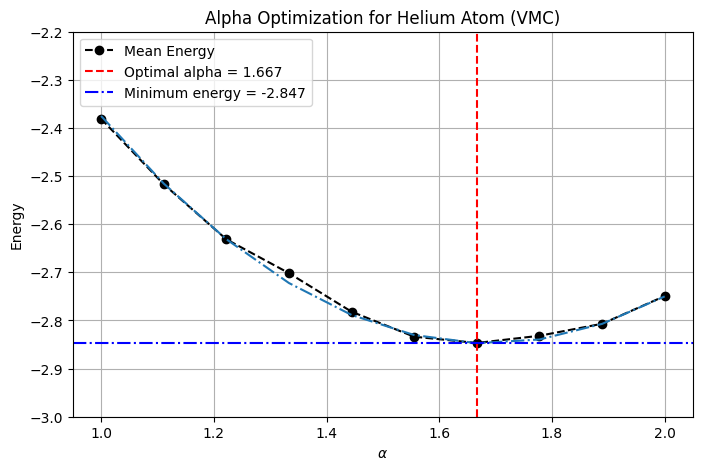

In [10]:

plt.figure(figsize=(8, 5))
plt.plot(alpha_range, mean_energy, 'o-', label='Mean Energy', linestyle = '--', color='k')
plt.plot(alpha_range, alpha_range**2-4*alpha_range+(5/8)*alpha_range, linestyle = '-.')
plt.axvline(optimal_alpha, color='r', linestyle='--', label=f'Optimal alpha = {optimal_alpha:.3f}')
plt.axhline(np.min(mean_energy), color='b', linestyle = '-.', label=f'Minimum energy = {np.min(mean_energy):.3f}')
plt.xlabel(r'$\alpha$')
plt.ylabel('Energy')
plt.title('Alpha Optimization for Helium Atom (VMC)')
plt.legend()
plt.grid(True)
plt.ylim(-3,-2.2)
plt.show()

In [11]:
from IPython.display import display, Math

display(Math(r"\alpha \quad \quad \quad \quad \langle H \rangle \quad \quad \quad \quad \quad \quad  \sigma^2"))

for i in range(len(alpha_range)):
    print(f"{round(alpha_range[i], 4)}\t{round(mean_energy[i], 4)}\t \t{round(variance[i], 4)}")

<IPython.core.display.Math object>

1.0	-2.3809	 	1.7376
1.1111	-2.5169	 	1.8118
1.2222	-2.6313	 	1.6442
1.3333	-2.7017	 	1.3552
1.4444	-2.7818	 	1.2829
1.5556	-2.8338	 	1.0809
1.6667	-2.8467	 	0.8922
1.7778	-2.8318	 	0.8891
1.8889	-2.8069	 	0.8366
2.0	-2.7493	 	1.0912
